## Still needs to be done:
- implement a way to evaluate fit, not just which is best
- add if loop for missing erosion map
- add possibility to input interpolated bedrock map
- check interpolation function...

- implement interactive plots in plotly?
- draw inputs from a txt file?

### Import libraries

In [1]:
import numpy as np                  # library for arrays 
import pandas as pd                 # library for tables 
import geopandas as gpd             # library for georeferenced tables 
import matplotlib.pyplot as plt     # plotting library
import matplotlib.gridspec as gs    # library to make gridded subplots
from matplotlib.pyplot import cm    # colour management liibrary
import seaborn as sns               # pretty statistical plotting library
import scipy.interpolate as intr    # interpolation functions
import utm                          # conversion from and to UTM coordinates
from os import mkdir, path          # operating system utilities

# this command displays plots below the related cell
%matplotlib inline

# Alternatively, this command makes matplotlib open an interactive window everytime a figure is produced
# %matplotlib notebook 

sns.set(style='white', context='talk') # all plots have white background and large fontsize

### Specify input files and parameters

In [2]:
# Input rasters as ASCII files, with .txt or .asc extension
# Best resampled to a reasonably low resolution before importing it.
# If not, no big deal, but computational time increases
# Input Coordinate Reference System must be WGS1984
dem_filename = 'dem.txt' # digital elevation model
e_map_filenames = ['e_map0.asc','slope_map.asc'] # list of erosion maps with same extent as DEM, each cell has an erosional weigth

# watershed shapefile filename with .shp extension
ws_filename = 'ws_lc.shp'

# Input bedrock and detrital ages filenames, with .xlsx extension
# This should be a table with the following header:
# lat, lon, elev, age, sd
bedrock_ages_filename = 'bedrock_data.xlsx'
detrital_ages_filename = 'detrital_data.xlsx'

# Input target resolution of the interpolated surface [meters]
res = 500  

# How do you want to name the input folder for this simulation?
ipf = 'input'

# How do you want to name the output folder for this simulation?
opf = 'output'

### Import input files and display them

In [3]:
########################## Open DEM and read the metadata ################################
##########################################################################################

# make DEM class
class DEM:
    def __init__(self, name):
        self.name = name

    def from_ascii(self, filename):
        '''
        Function to read an ASCII raster, most commonly exported from ArcGIS or QGIS.
        The first 6 lines must inform:

        ncols
        nrows
        xllcorner  
        yllcorner  
        cellsize   
        NODATA_value

        followed by the raster values separated by spaces

        if verbose=False, metadata is not printed, but only returned
        '''

        # read DEM text file
        fid = open(ipf+'/'+filename, 'r')

        # make a table of the dem info and convert values tosuitable data types (integer, float)
        dem_info = [fid.readline().split() for i in range(6)]
        dem_info = np.array(dem_info).transpose()
        dem_info = dict([(k,v) for k,v in zip(dem_info[0],dem_info[1])])
        dtypes = (int,int,float,float,float,float)
        for i,f in zip(dem_info,dtypes):
            dem_info[i]=f(dem_info[i])

        # get the dem data as a list of strings
        dem_ls_of_str = [fid.readline().split() for i in range(dem_info['nrows'])]

        # then convert all strings to floats
        dem = np.array([[float(i) for i in dem_ls_of_str[j]] for j in range(dem_info['nrows'])])
        if dem.shape != (dem_info['nrows'], dem_info['ncols']):
            print('something went wrong while parsing the DEM, nrows and/or ncols do not match the original input')

        # change NODATA_value to np.nan
        dem[dem==dem_info['NODATA_value']]=np.nan
        
        self.z = dem
        self.info_dict = dem_info
        # specify the figure's geographical extent in lat,lon
        self.xllcorner = dem_info['xllcorner']
        self.yllcorner = dem_info['yllcorner']
        self.ncols = dem_info['ncols']
        self.nrows = dem_info['nrows']
        self.cellsize = dem_info['cellsize']
        self.nodata = dem_info['NODATA_value']
        self.extent84 = (self.xllcorner, self.xllcorner+self.ncols*self.cellsize,
                         self.yllcorner, self.yllcorner+self.nrows*self.cellsize)
        
        # build coordinate grids and arrays
        # convert llcorner and urcorner coordinates to utm and define extentUTM
        self.xyll = utm.from_latlon(self.extent84[2], self.extent84[0]) #force_zone_number=19
        self.xyur = utm.from_latlon(self.extent84[3], self.extent84[1]) #force_zone_number=19
        self.extentUTM = (self.xyll[0], self.xyur[0], self.xyll[1], self.xyur[1])

        # make easting and northing vectors
        Xi = np.linspace(self.xyll[0], self.xyur[0], self.ncols)
        Yi = np.linspace(self.xyll[1], self.xyur[1], self.nrows)
        self.xi, yi = np.meshgrid(Xi,Yi)
        self.yi = yi[::-1] ################ flipped row order for latitude to decrease from top
        # 1d vectors, needed for linear interpolation
        self.xi_1d = self.xi.reshape(dem.size)
        self.yi_1d = self.yi.reshape(dem.size)
        self.zi_1d = dem.reshape(dem.size)
        
    def info(self):
        # Print details of imported DEM, except nodata value
        print('')
        print('METADATA OF '+self.name)
        print('')
        print('xllcorner = {}'.format(self.xllcorner))
        print('yllcorner = {}'.format(self.yllcorner))
        print('ncols = {}'.format(self.ncols))
        print('nrows = {}'.format(self.nrows))
        print('cellsize [km] = {}'.format(self.cellsize))
        print('cellsize [m] = ~{}'.format(int(np.around(self.cellsize*110000,1)/10)*10))
        print('min value = {}'.format(np.nanmin(self.z)))
        print('max value = {}'.format(np.nanmax(self.z)))
        print('NODATA_value = {}'.format(self.nodata))

    def resample(self, res, xyll=None, xyur=None, extent84=None, method='nearest'):
        '''
        Method to resample the input rasters to desired resolution .
        By default it uses a nearest neighbour algorithm
        res = resolution in meters
        xyll = (x,y) coordinates of lower left corner of target extent of the resampled dem
        xyur = (x,y) coordinates of upper right corner of target extent of the resampled dem
        extent84 = (left,right,bottom,top) in lon-lat, of the target extent of the resampled dem
        method --> https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
        '''
        if xyll == None:
            xyll=self.xyll
        if xyur == None:
            xyur=self.xyur
        if extent84 == None:
            extent84=self.extent84
        # first make resampled easting and northing vectors
        Xi_res = np.arange(xyll[0], xyur[0]+res, res)
        Yi_res = np.arange(xyll[1], xyur[1]+res, res)
        self.xi_res, yi_res = np.meshgrid(Xi_res, Yi_res)
        self.yi_res = yi_res[::-1] ################# flipped row order for latitude to decrease from top
        self.xi_res_1d = self.xi_res.reshape(self.xi_res.size)
        self.yi_res_1d = self.yi_res.reshape(self.xi_res.size)

        # also make lon-lat vectors at same resolution
        Xi_res84 = np.linspace(extent84[0], extent84[1], self.xi_res.shape[1])
        Yi_res84 = np.linspace(extent84[2], extent84[3], self.xi_res.shape[0])
        self.xi_res84, yi_res84 = np.meshgrid(Xi_res84,Yi_res84)
        self.yi_res84 = yi_res84[::-1] ############## flipped row order for latitude to decrease from top

        # resample by interpolating at new grid nodes with resolution "res"
        # input_coords are organized in a 2D array, with columns representing x,y
        input_coords = np.concatenate(([self.xi_1d],[self.yi_1d])).transpose()
        # resampled coords are organized in a 2D array, with columns representing x,y
        self.res_coords = np.concatenate(([self.xi_res_1d],[self.yi_res_1d])).transpose()
        # Now resample: the 'values' variable refers to the known elevations of the input dem
        self.zi_res_1d = intr.griddata(points=input_coords, values=self.zi_1d, xi=self.res_coords, method=method)
        self.zi_res = self.zi_res_1d.reshape(self.xi_res.shape) # reshape from 1D to 2D
        
dem = DEM('topography')
dem.from_ascii(dem_filename)
dem.info()
e_maps = {}
count=0
for i in e_map_filenames:
    count+=1
    key = i[:i.find('.')]
    e_maps[key] = DEM(key)
    e_maps[key].from_ascii(i)
    e_maps[key].info()

max_e = max([np.nanmax(m.z) for k,m in e_maps.items()])


METADATA OF topography

xllcorner = -71.200416424533
yllcorner = -33.000416206563
ncols = 241
nrows = 121
cellsize [km] = 0.000833333333
cellsize [m] = ~90
min value = 137.0
max value = 2218.0
NODATA_value = -9999.0

METADATA OF e_map0

xllcorner = -71.200416424533
yllcorner = -33.000416206563
ncols = 241
nrows = 121
cellsize [km] = 0.000833333333
cellsize [m] = ~90
min value = 0.0
max value = 100.0
NODATA_value = -9999.0

METADATA OF slope_map

xllcorner = -71.202923984545
yllcorner = -33.004067025942
ncols = 247
nrows = 130
cellsize [km] = 0.000829669819
cellsize [m] = ~90
min value = 0.0
max value = 55.53640365600586
NODATA_value = -9999.0


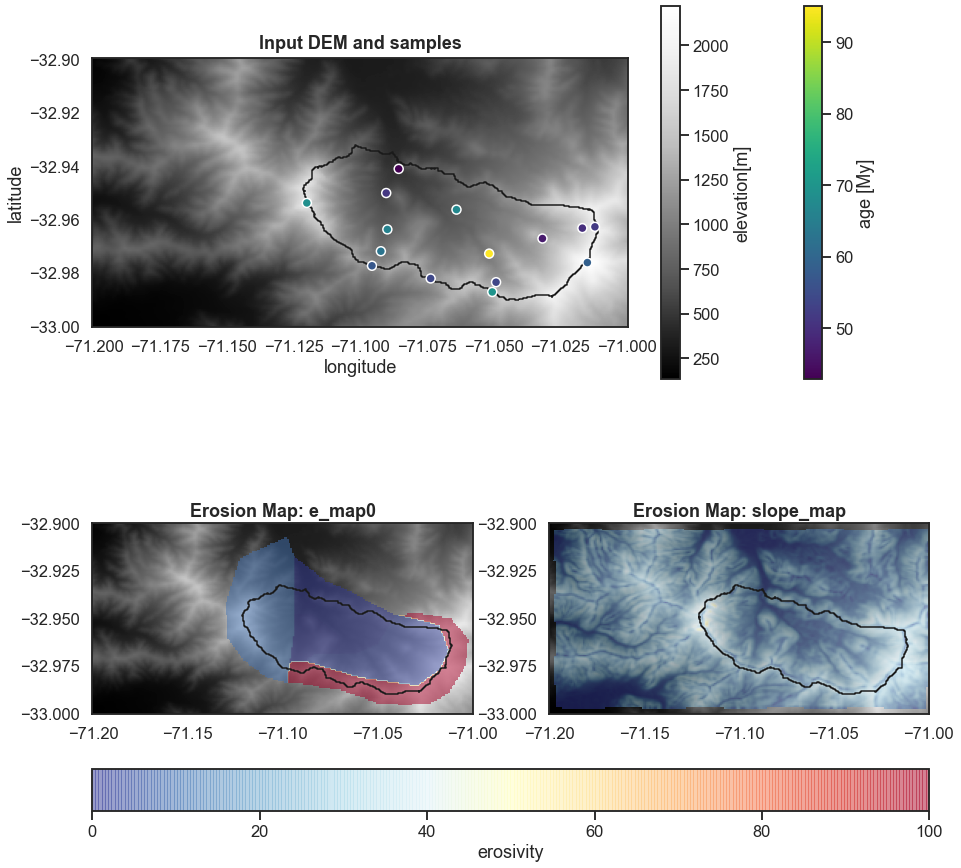

In [4]:
################# Now import age dataset into a pd.DataFrame ##############################
##########################################################################################

bd = pd.read_excel(ipf+'/'+bedrock_ages_filename)

z = bd.elev.values
if z.mean()<10:
    z = z*1000 # convert elevations from km to meters, if that's the case
a = bd.age.values
u = bd.sd.values
lat = bd.lat.values
lon = bd.lon.values

# convert from geographic to projected coordinates,
# otherwise the interpolation will overestimate the role of elevation and produce funny results.
# preallocate arrays
x_utm = np.array([])
y_utm = np.array([])
for i,v in enumerate(lat):
    xy_utm = utm.from_latlon(lat[i], lon[i]) #force_zone_number=19
    x_utm = np.append(x_utm, xy_utm[0])
    y_utm = np.append(y_utm, xy_utm[1])

# add points at -5000 m below sample elevation (zero cooling age depth) to arrays
# such that each x,y location has a double with age=0 and elev=z-5000
xx_utm = x_utm # double letters are the doubled vectors from now on (e.g. xx, yy...)
yy_utm = y_utm
zz = z
aa = a
for i,v in enumerate(z):
    xx_utm = np.append(xx_utm, x_utm[i])
    yy_utm = np.append(yy_utm, y_utm[i])
    zz = np.append(zz, v-5000)
    aa = np.append(aa, 1e-9)
    
################# Now import watershed outline as geopandas.DataFrame ##############################
##########################################################################################

ws_outline = gpd.read_file(ipf+'/'+ws_filename)

######################### Now plot dem and data points to check that everything worked fine ########
####################################################################################################

# make figure, gridspec and axes
# you can edit the parameter "figsize" if the aspect ratio doesn't fit
fig = plt.figure(figsize=(15,15*2*dem.nrows/dem.ncols))
gspec = gs.GridSpec(2,len(e_maps.keys()),figure=fig)

# raster plot
ax1 = fig.add_subplot(gspec[0,:]) # first row of plot
im = ax1.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
# polygon plot
poly = ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
# scatter plot
sct = ax1.scatter(lon, lat, c=a, cmap='viridis', edgecolor='w')
ax1.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax1.set_title('Input DEM and samples',pad=10, fontdict=dict(weight='bold'))
# colorbar
cb2 = fig.colorbar(sct)
cb2.set_label('age [My]')
cb1 = fig.colorbar(im)
cb1.set_label('elevation[m]')

# plot imported erosional maps
count = 0
row2 = []
for k,i in e_maps.items():
    count+=1
    ax = fig.add_subplot(gspec[1,count-1])
    row2.append(ax)
    im2= ax.imshow(dem.z, origin='upper', cmap='Greys_r', extent=dem.extent84)
    em = ax.imshow(i.z, origin='upper', cmap='RdYlBu_r', extent=dem.extent84, alpha=0.5, vmin=0, vmax=max_e)
    ws_outline.plot(edgecolor='k',facecolor='None',ax=ax)
    ax.set_title('Erosion Map: '+k, fontdict=dict(weight='bold'))
    if count == gspec.get_geometry()[1]:
        cb3 = fig.colorbar(em,orientation='horizontal',ax=row2)
        cb3.set_label('erosivity')

# make output directory
if not path.exists(opf):
    mkdir(opf)

# and save figure
fig.savefig(opf+'/input_data.pdf', dpi=200)

### Resample DEM and interpolate ages to that topographic surface

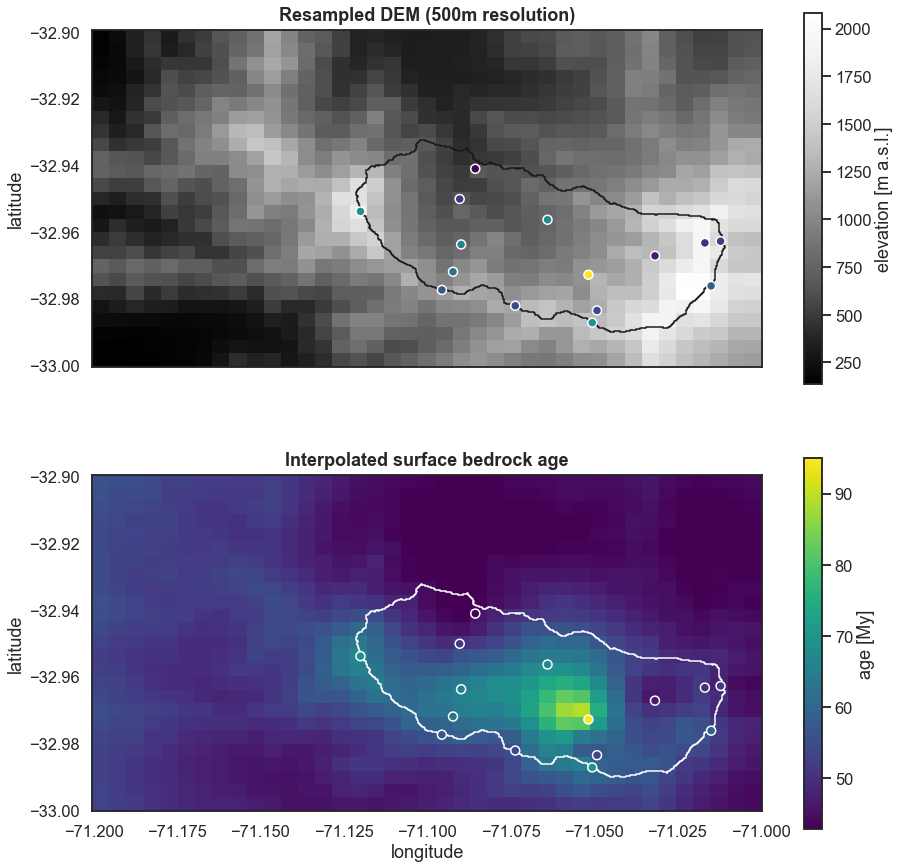

In [5]:
dem.resample(res)
e_maps_res = {}
for k,i in e_maps.items():
    i.resample(res, xyll=dem.xyll, xyur=dem.xyur, extent84=dem.extent84)

########################## Interpolate age data onto the topographic surface #######################
####################################################################################################

# known data points, for which the interpolation function is found
# they are organized in a 2D array, with columns representing x,y,z
pts = np.concatenate(([xx_utm],[yy_utm],[zz])).transpose()

# positions where interpolation needs to be made (all the catchment's gridcells)
# they are organized in a 2D array, with columns representing x,y,z
pos = np.concatenate(([dem.xi_res_1d],[dem.yi_res_1d],[dem.zi_res_1d])).transpose()

# Now run the interpolation.
# with either Radial Basis Functions
rbfi = intr.Rbf(xx_utm, yy_utm, zz, aa, function='linear')
age_interp_map = rbfi(dem.xi_res, dem.yi_res, dem.zi_res)
age_interp = age_interp_map.reshape(age_interp_map.size)

#################################### Plot it ##################################################
###################################################################################################
  
fig = plt.figure(figsize=(15,15))
gspec = gs.GridSpec(2,1,figure=fig)

ax1 = fig.add_subplot(gspec[0])

im1 = ax1.imshow(dem.zi_res, origin='upper', extent=dem.extent84, cmap='Greys_r')
ws_outline.plot(edgecolor='k',facecolor='None',ax=ax1)
ax1.set(aspect='equal', ylabel='latitude', xticks=[])
ax1.set_title('Resampled DEM ('+str(res)+'m resolution)', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im1)
cb.set_label('elevation [m a.s.l.]')

ax2 = fig.add_subplot(gspec[1])

# plot bedrock surface age map
im2 = ax2.imshow(age_interp_map, origin='upper', extent=dem.extent84, cmap='viridis',
                 vmin=a.min(), vmax=a.max(), alpha=1)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax2)
ax2.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax2.set_title('Interpolated surface bedrock age', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im2)
cb.set_label('age [My]')


# plot samples and ages
for ax in [ax1,ax2]:
    ax.scatter(x=lon, y=lat, c=a, cmap='viridis', vmin=a.min(), vmax=a.max(), edgecolor='w')
    
# save fig
fig.savefig(opf+'/DEMres'+str(res)+'_ageinterp.pdf', dpi=200)

### Produce error map through bootstrapping

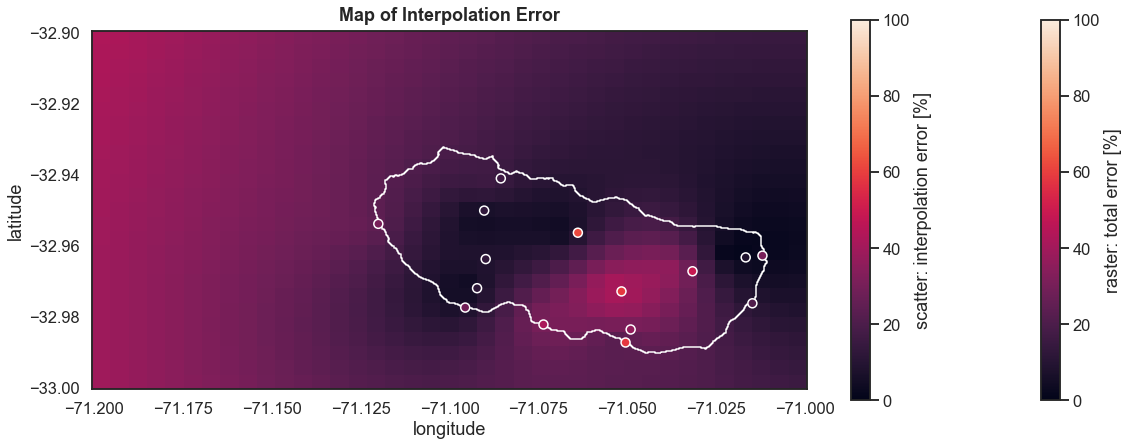

In [6]:
# pre-allocate a vector with as many elements as bedrock samples
error_interp = np.zeros(lat.size)

# Bootstrap:
# for each bedrock sample
# 1. exclude the related point from input data
# 2. calculate an interpolated surface age at its location
# 3. save the difference to the known measured age.
for i in np.arange(lat.size):
    a_boot = np.delete(aa, i)
    x_boot = np.delete(xx_utm, i)
    y_boot = np.delete(yy_utm, i)
    z_boot = np.delete(zz, i)
    
    # use Radial Basis Function interpolation
    rbfi = intr.Rbf(x_boot, y_boot, z_boot, a_boot, function='linear')
    a_int = rbfi(xx_utm[i], yy_utm[i], zz[i]) # get interpolated age of excluded sample
    
    error_interp[i] = abs(aa[i]-a_int)/aa[i]*100
    
# calculate sqrt of the square error_interp + square age_sd
error_total = np.sqrt(error_interp**2+(u/a*100)**2)
# substitute nans at edge of interpolation with mean error
error_total[error_total!=error_total] = np.nanmean(error_total)

##################################### Now make the map ################################
###################################################################################
# with RBF
rbfi = intr.Rbf(x_utm, y_utm, error_interp, function='linear') # not considering elevation here
age_interp_error_map = rbfi(dem.xi_res, dem.yi_res) # get interpolated age of excluded sample    


##################################### Plot the error map ################################
#########################################################################################

fig,ax = plt.subplots(1,1,figsize=(20,7))

# plot error map
im = ax.imshow(age_interp_error_map, origin='upper', extent=dem.extent84, vmin=0, vmax=100)

ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
sct = ax.scatter(x=lon, y=lat, c=error_total, edgecolor='w', vmin=0, vmax=100)

ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Map of Interpolation Error', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im)
cb1 = fig.colorbar(sct)
cb.set_label('raster: total error [%]')
cb1.set_label('scatter: interpolation error [%]')

# save fig
fig.savefig(opf+'/age_interp_error_map.pdf', dpi=200)

## Clip to watershed 

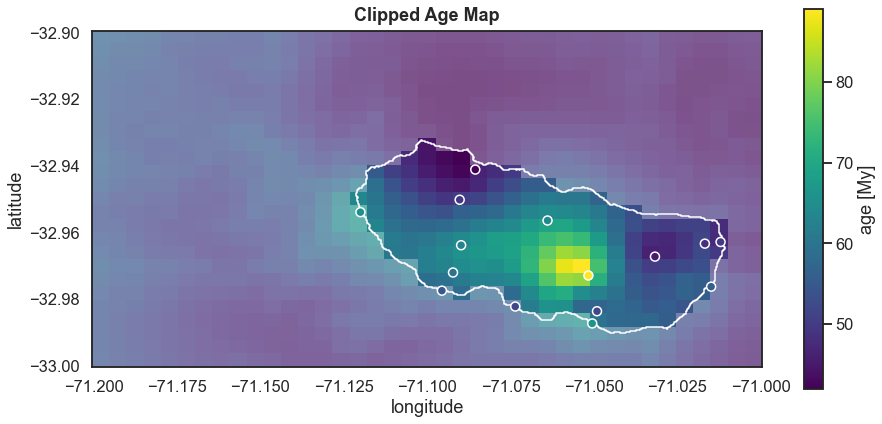

In [7]:
def clip_to_ws(raster, shp_filename, extent):
    '''
    This function clips the input raster to the watershed shapefile,
    so that all raster cells can be used to predict detrital distributions
    - raster: 2D np.array
    - shp_filename: string, filename of the watershed shapefile
    - extent: tuple or list, extent of the raster in wgs1984 (west, east, south, north)
    '''
    import fiona
    import rasterio
    from rasterio.plot import show
    from rasterio.mask import mask
    from shapely.geometry import Polygon
    
    # calculate x and y cellsize in degrees
    xsize = np.abs(extent[0]-extent[1])/raster.shape[1]
    ysize = np.abs(extent[2]-extent[3])/raster.shape[0]
    # define rasterio transform function
    transform = rasterio.transform.from_origin(extent[0], extent[3], xsize, ysize)
    # define coordinate reference system to wgs1984
    crs = rasterio.crs.CRS.from_epsg(4326) # wgs1984: 4326
    # make new raster file based on input, necessary step to use rasterio's functions,
    # and define the metadata
    src = rasterio.open(opf+'/raster.tif', 'w', driver='GTiff',
                        height = raster.shape[0], width = raster.shape[1],
                        count = 1, dtype = str(raster.dtype),
                        crs = crs, transform=transform)
    # write and close the new tif file
    src.write(raster, 1)
    src.close()
    # get watershed polygon vertices 
    with fiona.open(ipf+'/'+shp_filename,'r') as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    # read the raster and make masking information
    with rasterio.open(opf+'/raster.tif','r') as src:
        out_image, out_transform = mask(src, shapes, nodata=np.nan)
        out_meta = src.meta
    # update the metadata accordingly
    out_meta.update({"driver": "GTiff", "height": out_image.shape[1],
                     "width": out_image.shape[2], "transform": out_transform})
    # write the clipped raster
    with rasterio.open(opf+'/raster_clipped.tif', 'w', **out_meta) as dest:
        dest.write(out_image)
        
    return rasterio.open(opf+'/raster_clipped.tif').read(1)

# clip all rasters to watershed
xi_res_clp = clip_to_ws(dem.xi_res, ws_filename, dem.extent84)
yi_res_clp = clip_to_ws(dem.yi_res, ws_filename, dem.extent84)
zi_res_clp = clip_to_ws(dem.zi_res, ws_filename, dem.extent84)

e_maps_res_clp = dict()
for k,i in e_maps.items():
    e_maps_res_clp[k] = clip_to_ws(i.zi_res, ws_filename, dem.extent84)

age_interp_map_clp = clip_to_ws(age_interp_map, ws_filename, dem.extent84)
age_interp_error_map_clp = clip_to_ws(age_interp_error_map, ws_filename, dem.extent84)

# plot the clipped age map
fig, ax = plt.subplots(figsize=(15,7))
ax.imshow(age_interp_map, extent=dem.extent84, origin='upper', cmap='viridis', alpha=0.7)
im = ax.imshow(age_interp_map_clp, extent=dem.extent84, origin='upper', cmap='viridis')
ws_outline.plot(edgecolor='w',facecolor='None',ax=ax)
ax.scatter(x=lon, y=lat, c=a, edgecolor='w', cmap='viridis')
ax.set(aspect='equal', xlabel='longitude', ylabel='latitude')
ax.set_title('Clipped Age Map', pad=10, fontdict=dict(weight='bold'))
cb = fig.colorbar(im)
cb.set_label('age [My]')

# save fig
fig.savefig(opf+'/clipped_age_map.pdf', dpi=200)

# age_interp_error_map = ws.read(1)
# age_interp_error = age_interp_error_map.reshape(age_interp_error_map.size)

## Make a table of x, y, elev, age, error, erosion

In [8]:
grids = [xi_res_clp, yi_res_clp, zi_res_clp, age_interp_map_clp, age_interp_error_map_clp] # grids to crop
labels = ['x', 'y', 'z', 'age', 'age_u%'] # labels for dictionary
for k,i in e_maps_res_clp.items():
    labels.append(k)
    grids.append(i)

ws_data = pd.DataFrame()
for g,l in zip(grids,labels):
    ws_data[l] = g[g==g] # drop the nans and reshape to 1D-array
    
# For the examples, make erosional weight as an exponential and inverse exponential function of elevation
ws_data['E_exp_Z'] = np.exp(ws_data.z/ws_data.z.min())
ws_data.E_exp_Z = ws_data.E_exp_Z/ws_data.E_exp_Z.min()
ws_data['E_inv_exp_Z'] = 1/np.exp(ws_data.z/ws_data.z.min())
ws_data.E_inv_exp_Z = ws_data.E_inv_exp_Z/ws_data.E_inv_exp_Z.min()
    
# save to excel
ws_data.to_excel(opf+'/xyz_age_eros.xlsx', index=False)

ws_data.head()

,x,y,z,age,age_u%,e_map0,slope_map,E_exp_Z,E_inv_exp_Z
0,303926.515795,6.354516e+06,676.0,44.423737,19.448145,10.0,24.463518,1.715772,24.543709
1,303426.515795,6.354016e+06,846.0,47.594167,19.427375,10.0,9.773893,2.527188,16.663352
2,303926.515795,6.354016e+06,621.0,44.491917,18.251585,10.0,21.832550,1.513733,27.819586
3,304426.515795,6.354016e+06,521.0,42.828284,17.577943,1.0,14.681509,1.205372,34.936452
4,304926.515795,6.354016e+06,439.0,41.874136,17.017198,1.0,3.095420,1.000000,42.111418


## Make grain populations for all erosion scenarios and related distributions

In [9]:
# make populations according to the different erosion weighting
multiplier = 10 # starting number of grains for each cell (the more the better, but also slower...)
pops = {} # preallocate dictionary of populations
scen_labels = ws_data.columns[5:].to_list() # ['E_exp_Z','E_inv_exp_Z','E_map']
for s in scen_labels:
    # label of the column that informs how many grains (N) per cell
    N_label = 'N_'+s
    # assign to each cell an amount of grains proportional to the erosional weight
    ws_data[N_label] = np.rint(ws_data[s]*multiplier)
    # make a gaussian distribution for each cell
    # Draw from it as many ages as grains and store them in a 1D-array, in the populations dictionary
    pops[s] = np.array([])
    for a,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data[N_label]):
        pops[s] = np.append(pops[s], np.random.normal(a,a*u/100,int(N)))

# make uniform erosion population in the same way
ws_data['N_Euni'] = np.ones(len(ws_data))*multiplier
pops['Euni'] = np.array([])
for a,u,N in zip(ws_data.age, ws_data['age_u%'], ws_data['N_Euni']):
    pops['Euni'] = np.append(pops['Euni'], np.random.normal(a,a*u/100,int(N)))
# also load the detrital data
dd = pd.read_excel(ipf+'/'+detrital_ages_filename)
pops['detrital data'] = dd.age.values

def make_dists(pop):
    '''
    makes a normalized cdf of input population
    returns a dataframe with values, counts, frequency
    - pop: 1D np.array of ages, or list of ages
    '''
    pop = np.array(pop) # make array
    df = pd.DataFrame() # initialise dataframe
    df['vals'], df['valcount'] = np.unique(pop, return_counts=True)
    df.index = df.vals.apply(int) # use ages as index
    df['cdf_y'] = df.valcount.cumsum()/df.valcount.cumsum().iloc[-1] # make cumulative frequency
    return df

# preallocate dictionary of distributions
dists = {}
for label, pop in pops.items():
    dists[label] = make_dists(pop)

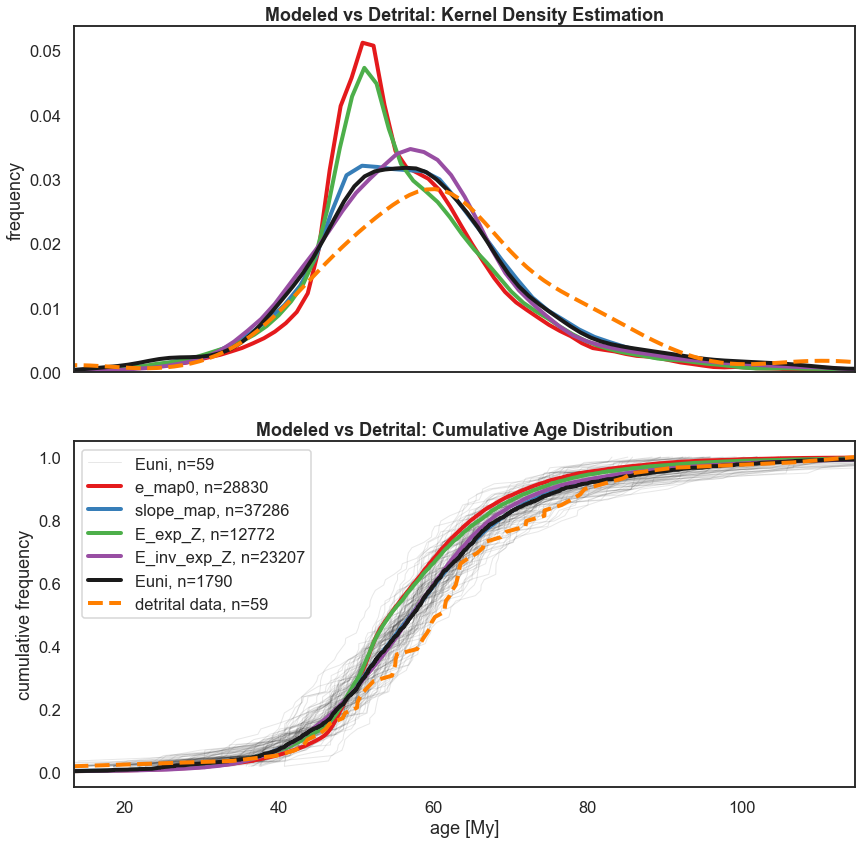

In [10]:
##################################### Plot distributions ################################
#########################################################################################
# define which is the reference erosion scenario
ref_scen = 'Euni'

fig = plt.figure(figsize=(14,14))
gspec = gs.GridSpec(2,1,figure=fig)
ax1 = fig.add_subplot(gspec[0])

# plot all scenarios pdf
color=iter(cm.Set1(np.linspace(0,1,9))) # np.linspace(0,1,len(scen_labels))
for scen,df in dists.items():
    if scen == ref_scen:
        c='k'
    else:
        c=next(color)
    if scen == 'detrital data':
        ls='--'
    else:
        ls='-'
    sns.distplot(pops[scen],hist=False,
                 kde_kws={'color':c,'linewidth':4,'linestyle':ls},label='_nolegend_', ax=ax1)
    
    ax1.set(xlim=(dd.age.min(),dd.age.max()), ylabel='frequency', xlabel='', xticks=[])
    ax1.set_title('Modeled vs Detrital: Kernel Density Estimation',
                 fontdict={'weight':'bold'})

# second row
ax2 = fig.add_subplot(gspec[1])

# plot all scenarios cdf, including 100 random subsamples of Euni
for i in np.arange(100):
    pop1 = np.random.choice(pops['Euni'],len(dd))
    if i==0:
        dist1 = make_dists(pop1)
        sns.lineplot(dist1.vals,dist1.cdf_y,
                     color='k', alpha=0.1, lw=1, ax=ax2, label='Euni, n='+str(len(dd)))
    else:
        dist1 = make_dists(pop1)
        sns.lineplot(dist1.vals, dist1.cdf_y,
                     color='k', alpha=0.1, lw=1, ax=ax2, label='_nolegend_')

color=iter(cm.Set1(np.linspace(0,1,9))) # np.linspace(0,1,len(scen_labels))
for scen,df in dists.items():
    if scen == ref_scen:
        c='k'
    else:
        c=next(color)
    if scen == 'detrital data':
        ls = '--'
    else:
        ls = '-'
    ax2.plot(df.vals, df.cdf_y, color=c, linestyle=ls, label=scen+', n='+str(df.valcount.sum()), lw=4)

ax2.set(xlim=(dd.age.min(),dd.age.max()), ylabel='cumulative frequency', xlabel='age [My]')
ax2.set_title('Modeled vs Detrital: Cumulative Age Distribution',
                 fontdict={'weight':'bold'})
ax2.legend()

# save fig
fig.savefig(opf+'/detrital_distributions.pdf', dpi=200)

## Confidence in discerning between erosion scenarios and 'Euni'
## as a function of sample size.

In [11]:
def get_KS(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    returns KS statistic
    '''
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)

    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # return KS statistic between real and interpolated from downsampled
    return max(np.abs(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y)-res_d))

def get_KL(res_p, d):
    '''
    res_p = resampled population p, with n=k
    d = real distribution of p
    bounds = limits of the distribution, defined at the beginning
    returns characteristic KL divergence at the chosen confidence level
    '''
    from scipy.stats import entropy
    res_p = np.array(res_p)
    res_p.sort()
    res_p_vals, res_p_valcount = np.unique(res_p, return_counts=True)
    res_d = res_p_valcount.cumsum()/res_p_valcount.sum()
    # return KL divergence between real and interpolated from downsampled
    return entropy(np.interp(x=res_p_vals,xp=d.vals,fp=d.cdf_y), res_d)

# Assign variables for iterations
all_k = np.arange(30,len(dd)+100,10) # possible N of dated grains (k) to consider
k_iter = 1000 # iterations per k value

# which statistic to be used? [get_KS, 'KS statistic'] , [get_KL,'KL divergence']  
stat = [get_KS, 'KS statistic']

# calculate 95% confidence divergence for each k, between 'Euni' n=∞ and 'Euni' n=len(dd)
Dc_within = {} # critical divergence between the reference scenario and the subsampled itself
D_dist_dict = {} # store distributions for later confidence plot
Dc = []
for k in all_k:
    # make array of integers (all equal k) with length k_iter
    k_array = (np.ones(k_iter)*k).astype(int)
    # get array of random divergencies, using chosen statistic
    D_arr = np.array([stat[0](np.random.choice(pops[ref_scen],k),dists[ref_scen]) for k in k_array])
    # sort values
    D_arr.sort()
    # calculate cumulative probability of each value
    D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
    D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
    ind95 = np.where(D_arr_prob<=0.95)[0][-1] # index of the 95th percentile
    # store values
    Dc.append(D_arr_vals[ind95])
    D_dist_dict[ref_scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]
Dc_within[ref_scen] = Dc

for scen in scen_labels:
    Dc = []
    for k in all_k:
        # make array of integers (all equal k) with length k_iter
        k_array = np.round(np.ones(k_iter)*k).astype(int)
        # get array of random divergences, using chosen statistic
        D_arr = np.array([stat[0](np.random.choice(pops[scen],k),dists[ref_scen]) for k in k_array])
        # sort values
        D_arr.sort()
        # calculate cumulative probability of each value
        D_arr_vals, D_arr_valcount = np.unique(D_arr, return_counts=True)
        D_arr_prob = D_arr_valcount.cumsum()/D_arr_valcount.sum()
        D_dist_dict[scen+'_'+str(k)] = [D_arr_vals, D_arr_prob, D_arr]

################ Calculate the confidence as function of the number of grains ########################
###############################################################################################

# Compare Dc_within to all scenarios for all k
# and get the probability of a scenario being discerned from reference for each k
probs = {}
for scen in scen_labels:
    probs1 = []
    for i in np.arange(len(all_k)): # for all k values
        # get index of element where Dc_within is smaller than Dc_between
        ind = np.where(D_dist_dict[scen+'_'+str(all_k[i])][0]>Dc_within[ref_scen][i])[0][0]
        # get complementary probability of ind,
        # because we're interested in how many values are larger than that (not smaller)
        probs1.append(100*(1-D_dist_dict[scen+'_'+str(all_k[i])][1][ind])) 
    probs[scen] = probs1

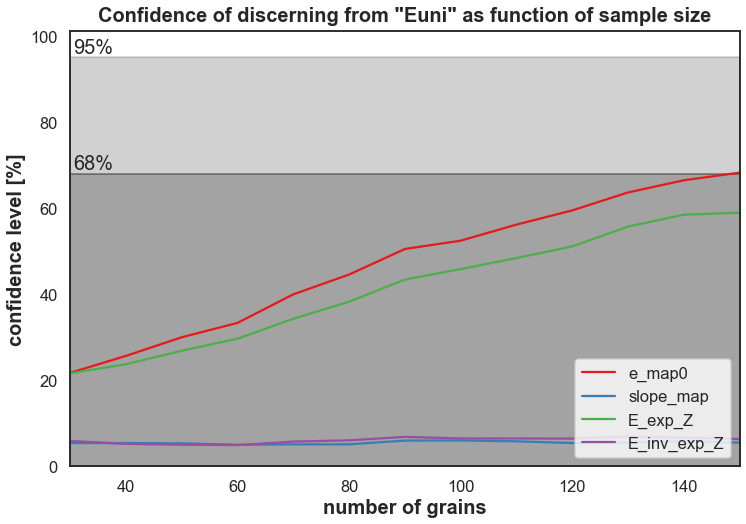

In [12]:
################ Plot the confidence as function of grain number ########################
#########################################################################################

def smooth(y, window_size=3, order=1, deriv=0, rate=1):
    '''
    dirty smoothing function, so that curves can be calculated on the base of ~1000 iterations,
    but still look good, if wanted
    '''
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        print("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y1 = np.concatenate((firstvals, y, lastvals))
    y_new = np.convolve( m[::-1], y1, mode='valid')
    y_new[0] = y[0]
    return y_new

def plot_confidence(prob_dict, all_k, saveas='scenarios_confidence_sample_size.pdf'):
    '''
    plots the confidence level as function of sample size
    prob_dict: dictionary of arrays, each containing confidence values related to all_k
    all_k: 1D-array of k values (integers)
    '''
    sns.set_style('white')
    fig,ax = plt.subplots(figsize=(12,8))
    # plot grey fields
    ax.fill_between([all_k[0],all_k[-1]],[95,95],[68,68],color='k',alpha=0.2)
    ax.text(all_k[0]+0.5,96,'95%',fontdict=dict(size=20))
    ax.fill_between([all_k[0],all_k[-1]],[68,68],color='k',alpha=0.4)
    ax.text(all_k[0]+0.5,69,'68%',fontdict=dict(size=20))
    color=iter(cm.Set1(np.linspace(0,1,9)))
    leg=[]
    for key,i in prob_dict.items():
        c = next(color)
        ax.plot(all_k,
                smooth(i),
                c=c,
                alpha=1)
        leg.append(key)
    ax.set(xlim=(all_k[0],all_k[-1]), ylim=(0,101), yticks=[0,20,40,60,80,100])
    ax.set_xlabel('number of grains',fontdict=dict(size=20, weight='bold'))
    ax.set_ylabel('confidence level [%]',fontdict=dict(size=20, weight='bold'))
    ax.set_title('Confidence of discerning from "'+ref_scen+'" as function of sample size',
                 fontdict=dict(size=20,weight='bold'), pad=10)
    ax.legend(leg, loc='lower right')
    
    fig.savefig(opf+'/'+saveas, dpi=200)
    
plot_confidence(prob_dict=probs, all_k=all_k)

## How do the different scenarios fit to the detrital data?

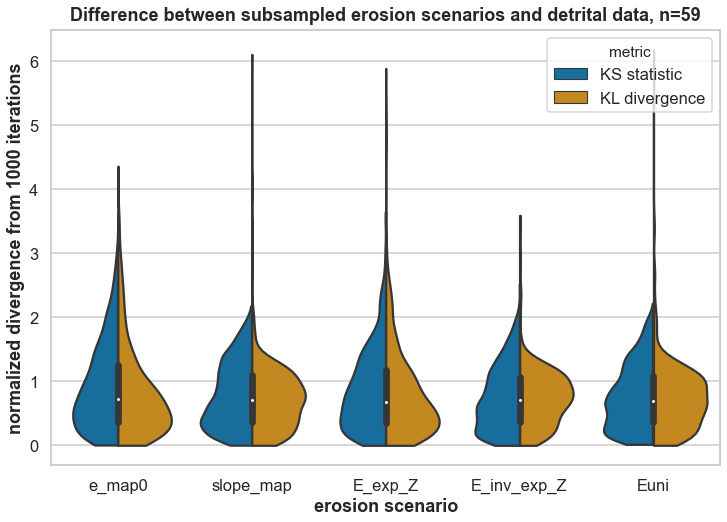

In [16]:
# allocate dataframe to store all iteration results
iter_results = pd.DataFrame(columns=['divergence','metric','scenario'])
KS_list = [] # empty list to receive KS statistic of each iteration
KL_list = [] # empty list to receive KL divergence of each iteration
scenario_list = [] # empty list to receive scenario name of each iteration

# array of sample sizes, all equal to number of measured grains
k_array = np.round(np.ones(k_iter)*len(dd)).astype(int)

# iterate through erosion scenarios
for scen in scen_labels+[ref_scen]:
    KS_list1 = [get_KS(np.random.choice(pops[scen],k),dists['detrital data']) for k in k_array]
    KL_list1 = [get_KL(np.random.choice(pops[scen],k),dists['detrital data']) for k in k_array]
    KS_list = KS_list + KS_list1
    KL_list = KL_list + KL_list1
    scenario_list = scenario_list + [scen for i in KS_list1]
# write dataframe
iter_results.divergence = KS_list + KL_list
iter_results.metric = ['KS statistic' for i in KS_list] + ['KL divergence' for i in KL_list]
iter_results.scenario = scenario_list + scenario_list
# make column of div. normalized to mean of each metric
KS_arr, KL_arr = np.array(KS_list), np.array(KL_list)
iter_results['divergence_norm'] = np.append(np.abs(KS_arr-KS_arr.mean())/KS_arr.std(), np.abs(KL_arr-KL_arr.mean())/KL_arr.std())

sns.set_style('whitegrid')
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

# choose stat once again: [get_KS, 'KS statistic'] or [get_KL,'KL divergence']  
# stat = [get_KL,'KL divergence'] 

sns.violinplot(data=iter_results, x='scenario',y='divergence_norm', ax=ax,
               cut=0, hue='metric', split=True, scale='area', palette=sns.color_palette('colorblind'))

ax.set_xlabel('erosion scenario', fontdict={'weight':'bold'})
ax.set_ylabel('normalized divergence from '+str(k_iter)+' iterations',fontdict={'weight':'bold'})
ax.set_title('Difference between subsampled erosion scenarios and detrital data, n='+str(len(dd)), pad=10, fontdict={'weight':'bold'})

fig.savefig(opf+'/fit_to_detrital_data_violinplot.pdf', dpi=200)

## 3D Plotting example

In [14]:
# from matplotlib.colors import LightSource

# %matplotlib notebook

# # Set up plot
# fig, ax = plt.subplots(subplot_kw=dict(projection='3d'),figsize=(10,5))

# ls = LightSource(80,20)
# # To use a custom hillshading mode, override the built-in shading and pass
# # in the rgb colors of the shaded surface calculated from "shade".
# rgb = ls.shade(zi_res, cmap=cm.gist_earth,vert_exag=0.3,
#                blend_mode='soft',vmax=2200)
# surf = ax.plot_surface(xi_res84,yi_res84[::-1],zi_res,facecolors=rgb,
#                        linewidth=0, antialiased=False, shade=True)
# ax.set(xticks=[-71.2,-71.1,-71],yticks=[-33,-32.95,-32.9],zticks=[500,1000,1500,2000])
# ax.view_init(70, 115) #50,195